In [2]:
import pandas as pd
from sqlalchemy import lateral
from tqdm import tqdm
import copy
import  matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import pandas as pd




In [3]:
data = pd.read_csv('storage/train_data.csv')
data_filtered = pd.read_csv('Storage/cleaned.csv')
valid_df = pd.read_csv('Storage/valid.csv')

# Filtration

In [4]:
data = data[(data['lat']>59.656929822910136)&(data['lat']<60.374089897957774)]
data = data[(data['lon']>29.40635082565253)&(data['lon']<32.047397760963925)]
data_group =  data.groupby(['lon', 'lat']).size().reset_index(name='counts')

color_scale = [(0, 'orange'), (1,'red')]
fig = px.scatter_mapbox(data_group, 
                        lat="lat", 
                        lon="lon", 
                        color="counts",
                        color_continuous_scale=color_scale,
                        size="counts",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


In [5]:
#filter
data_group
data_group.sort_values(by=['counts'])
data_group =  data.groupby(['lon', 'lat']).size().reset_index(name='counts')
data['instances'] = [1]*len(data)
data2 = data.groupby(['point']).agg({'instances':'sum','likescount':'sum','commentscount':'sum','symbols_cnt':'sum','words_cnt':'sum','hashtags_cnt':'sum','mentions_cnt':'sum','links_cnt':'sum','emoji_cnt':'sum'  }).reset_index()
big_poly = data2[data2['instances'] > 672]['point'].tolist()
data_filtered = data[data['point'].isin(big_poly)] 
data_filtered =  data_filtered.groupby(['timestamp', 'point']).agg({'instances':'sum','likescount':'sum','commentscount':'sum','symbols_cnt':'sum','words_cnt':'sum','hashtags_cnt':'sum','mentions_cnt':'sum','links_cnt':'sum','emoji_cnt':'sum','lat':'mean','lon':'mean'   }).reset_index()

#data_filtered.to_csv('Storage/cleaned.csv')


## Fill 0

In [ ]:
#fill for all polys
iter = 0
for poly in tqdm(data_filtered['point'].unique().tolist()):
    
    one_point =  data_filtered[data_filtered['point'] == poly]
    timestamps_list = list(range(min(one_point['timestamp']), max(one_point['timestamp'])+3600, 3600))
    assert min(timestamps_list) == min(one_point['timestamp'])
    assert max(timestamps_list) == max(one_point['timestamp'])
    filled = pd.DataFrame()
    filled['timestamp'] = timestamps_list
    filled = pd.merge(filled, one_point, how="left", on=["timestamp"])
    filled['point'] = [filled['point'][0]]*len(filled)
    filled['lat'] = [filled['lat'][0]]*len(filled)
    filled['lon'] = [filled['lon'][0]]*len(filled)
    filled = filled.fillna(0)

    if iter == 0:
        filled_forall = copy.deepcopy(filled)
    else:
        filled_forall = pd.concat([filled_forall, filled], ignore_index=True)
    iter += 1

#filled_forall.to_csv('Storage/filled_cleaned.csv')



In [6]:
filled_forall = pd.read_csv('Storage/filled_cleaned.csv')


# Preliminary graphs

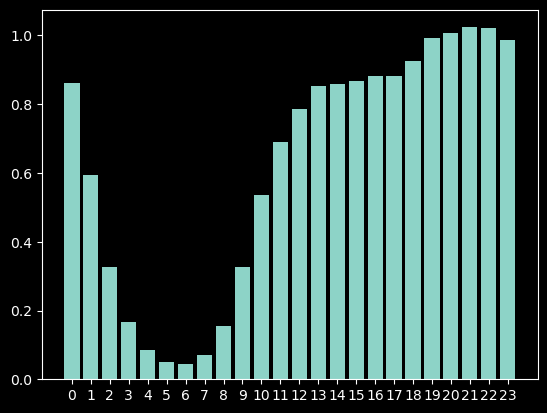

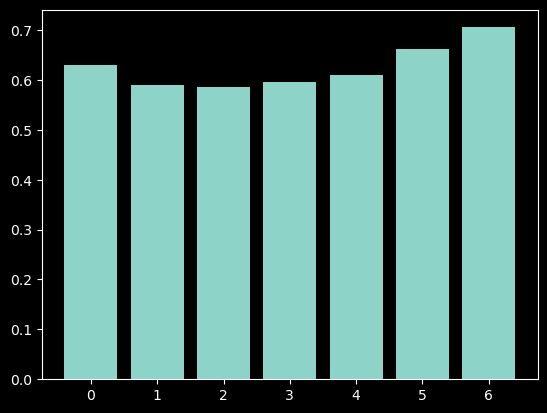

In [7]:
whole_data = filled_forall

whole_data['date'] = [datetime.fromtimestamp(x).date() for x in whole_data['timestamp']]
whole_data['hour'] = [datetime.fromtimestamp(x).hour for x in whole_data['timestamp']]
whole_data['weekday'] = [datetime.fromtimestamp(x).weekday() for x in whole_data['timestamp']]

group_by_hour = whole_data.groupby(['hour']).agg({'instances':'mean'}).reset_index()
group_by_day = whole_data.groupby(['weekday']).agg({'instances':'mean'}).reset_index()

#time distribution

y_pos = np.arange(len(group_by_hour))
# Create bars
plt.bar(y_pos, group_by_hour['instances'])
# Create names on the x-axis
plt.xticks(y_pos, group_by_hour['hour'])
# Show graphic
plt.show()

#day distribution
y_pos = np.arange(len(group_by_day))
# Create bars
plt.bar(y_pos, group_by_day['instances'])
# Create names on the x-axis
plt.xticks(y_pos, group_by_day['weekday'])
# Show graphic
plt.show()

## Filter Validation

In [8]:


differs = list(set(valid_df['point'].unique().tolist()) - set(data_filtered['point'].unique().tolist()))
valid_df = valid_df[valid_df['point'].isin(differs) == False]
valid_df[valid_df['point'] == valid_df['point'][0]].sort_values(by=['hour'])



,hour,lat,lon,point,sum,error
580,1580583600,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,7,0.504735
167,1580727600,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,6,1.754735
512,1581429600,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,6,1.754735
435,1581501600,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,11,4.254735
476,1581667200,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,7,5.754735
274,1581883200,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,8,6.754735
136,1582286400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.530979
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402


# Tests on loops

## Regression

In [10]:
from sklearn.linear_model import LinearRegression


In [16]:
errors_polis = []
bad = []

In [17]:
#run reg through all poligons

for poly_test in tqdm(valid_df['point'].unique().tolist()):
    
    train_df = filled_forall[filled_forall['point'] == poly_test]

    train_df['date'] = [datetime.fromtimestamp(x).date() for x in train_df['timestamp']]
    train_df['hour'] = [datetime.fromtimestamp(x).hour for x in train_df['timestamp']]
    train_df['weekday'] = [datetime.fromtimestamp(x).weekday() for x in train_df['timestamp']]

    train_df = train_df[['instances','hour', 'weekday']]
    y_train = train_df['instances']
    x_train = train_df[['hour', 'weekday']]
    test_df = valid_df[valid_df['point'] == poly_test].sort_values(by=['hour'])
    test_df['date'] = [datetime.fromtimestamp(x).date() for x in test_df['hour']]
    test_df['hour'] = [datetime.fromtimestamp(x).hour for x in test_df['hour']]
    test_df['weekday'] = [datetime.fromtimestamp(x).weekday() for x in test_df['hour']]
    test_df = test_df[['sum','hour', 'weekday']]
    y_test = test_df['sum']
    x_test = test_df[['hour', 'weekday']]
    model = LinearRegression()
    model.fit(x_train, y_train)
    model.score(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    y_pred_test = [x for x in y_pred_test]
    errors_polis.append(np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)))
    if np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)) >= 10:
        bad.append(poly_test)


100%|██████████| 154/154 [01:19<00:00,  1.94it/s]


In [18]:
np.mean(errors_polis)

4.779966593806892

## XGB

In [20]:
import xgboost as xgb
    
errors_polis = []
bad = []

In [21]:
for poly_test in tqdm(valid_df['point'].unique().tolist()):
    
    train_df = filled_forall[filled_forall['point'] == poly_test]

    train_df['date'] = [datetime.fromtimestamp(x).date() for x in train_df['timestamp']]
    train_df['hour'] = [datetime.fromtimestamp(x).hour for x in train_df['timestamp']]
    train_df['weekday'] = [datetime.fromtimestamp(x).weekday() for x in train_df['timestamp']]

    train_df = train_df[['instances','hour', 'weekday','lat','lon']]
    y_train = train_df['instances']
    x_train = train_df[['hour', 'weekday','lat','lon']]
    test_df = valid_df[valid_df['point'] == poly_test].sort_values(by=['hour'])
    test_df['date'] = [datetime.fromtimestamp(x).date() for x in test_df['hour']]
    test_df['hour'] = [datetime.fromtimestamp(x).hour for x in test_df['hour']]
    test_df['weekday'] = [datetime.fromtimestamp(x).weekday() for x in test_df['hour']]
    test_df = test_df[['sum','hour', 'weekday','lat','lon']]
    y_test = test_df['sum']
    x_test = test_df[['hour', 'weekday','lat','lon']]
    xgb_reg = xgb.XGBRegressor(n_estimators=50, max_depth=15)


    #model = LinearRegression()
    xgb_reg.fit(x_train, y_train)
    #model.score(x_train, y_train)
    y_pred_train = xgb_reg.predict(x_train)
    y_pred_test = xgb_reg.predict(x_test)
    y_pred_test = [x for x in y_pred_test]
    errors_polis.append(np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)))
    if np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)) >= 10:
        bad.append(poly_test)



100%|██████████| 154/154 [01:32<00:00,  1.67it/s]


In [22]:
np.mean(errors_polis)


3.809360604171403

## RF

In [25]:
from sklearn.ensemble import RandomForestRegressor
    
errors_polis = []
bad = []
rfc = RandomForestRegressor(n_estimators=100, max_depth=30, 
                            min_samples_split=16, warm_start=False)


In [26]:
for poly_test in tqdm(valid_df['point'].unique().tolist()):
    
    train_df = filled_forall[filled_forall['point'] == poly_test]

    train_df['date'] = [datetime.fromtimestamp(x).date() for x in train_df['timestamp']]
    train_df['hour'] = [datetime.fromtimestamp(x).hour for x in train_df['timestamp']]
    train_df['weekday'] = [datetime.fromtimestamp(x).weekday() for x in train_df['timestamp']]

    train_df = train_df[['instances','hour', 'weekday','lat','lon']]
    y_train = train_df['instances']
    x_train = train_df[['hour', 'weekday','lat','lon']]
    test_df = valid_df[valid_df['point'] == poly_test].sort_values(by=['hour'])
    test_df['date'] = [datetime.fromtimestamp(x).date() for x in test_df['hour']]
    test_df['hour'] = [datetime.fromtimestamp(x).hour for x in test_df['hour']]
    test_df['weekday'] = [datetime.fromtimestamp(x).weekday() for x in test_df['hour']]
    test_df = test_df[['sum','hour', 'weekday','lat','lon']]
    y_test = test_df['sum']
    x_test = test_df[['hour', 'weekday','lat','lon']]
    

    rfc = RandomForestRegressor(n_estimators=100, max_depth=30, 
                            min_samples_split=16, warm_start=False)

    
    rfc.fit(x_train, y_train)
    
    y_pred_train = rfc.predict(x_train)
    y_pred_test = rfc.predict(x_test)
    y_pred_test = [x for x in y_pred_test]
    errors_polis.append(np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)))
    if np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)) >= 10:
        bad.append(poly_test)



100%|██████████| 154/154 [01:54<00:00,  1.34it/s]


In [27]:
np.mean(errors_polis)

3.8264254755215017

## Dec Tree

In [28]:
from sklearn.tree import DecisionTreeRegressor
 
errors_polis = []
bad = []


In [29]:
for poly_test in tqdm(valid_df['point'].unique().tolist()):
    
    train_df = filled_forall[filled_forall['point'] == poly_test]

    train_df['date'] = [datetime.fromtimestamp(x).date() for x in train_df['timestamp']]
    train_df['hour'] = [datetime.fromtimestamp(x).hour for x in train_df['timestamp']]
    train_df['weekday'] = [datetime.fromtimestamp(x).weekday() for x in train_df['timestamp']]

    train_df = train_df[['instances','hour', 'weekday','lat','lon']]
    y_train = train_df['instances']
    x_train = train_df[['hour', 'weekday']]
    test_df = valid_df[valid_df['point'] == poly_test].sort_values(by=['hour'])
    test_df['date'] = [datetime.fromtimestamp(x).date() for x in test_df['hour']]
    test_df['hour'] = [datetime.fromtimestamp(x).hour for x in test_df['hour']]
    test_df['weekday'] = [datetime.fromtimestamp(x).weekday() for x in test_df['hour']]
    test_df = test_df[['sum','hour', 'weekday','lat','lon']]
    y_test = test_df['sum']
    x_test = test_df[['hour', 'weekday']]
    

    model = DecisionTreeRegressor()

    
    model.fit(x_train, y_train)
    
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    y_pred_test = [x for x in y_pred_test]
    errors_polis.append(np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)))
    if np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)) >= 10:
        bad.append(poly_test)

100%|██████████| 154/154 [01:14<00:00,  2.08it/s]


In [30]:
np.mean(errors_polis)


3.809797300690403

# Naive model

In [31]:
errors_polis = []
bad = []

In [32]:

for poly_test in tqdm(valid_df['point'].unique().tolist()):
    
    train_df = filled_forall[filled_forall['point'] == poly_test]
    distr = train_df.groupby(['weekday', 'hour']).agg({'instances':'mean'}).reset_index()


    train_df['date'] = [datetime.fromtimestamp(x).date() for x in train_df['timestamp']]
    train_df['hour'] = [datetime.fromtimestamp(x).hour for x in train_df['timestamp']]
    train_df['weekday'] = [datetime.fromtimestamp(x).weekday() for x in train_df['timestamp']]

    train_df = train_df[['instances','hour', 'weekday','lat','lon']]


    test_df = valid_df[valid_df['point'] == poly_test].sort_values(by=['hour'])
    test_df['date'] = [datetime.fromtimestamp(x).date() for x in test_df['hour']]
    test_df['hour'] = [datetime.fromtimestamp(x).hour for x in test_df['hour']]
    test_df['weekday'] = [datetime.fromtimestamp(x).weekday() for x in test_df['hour']]

    test_df = test_df[['sum','hour', 'weekday','lat','lon']]
    y_test = test_df['sum']
    x_test = test_df[['hour', 'weekday', 'sum']]
    
    new_df = pd.merge(x_test, distr,  how='left', left_on=['weekday','hour'], right_on = ['weekday','hour'])

    y_pred_test = new_df['instances']
    y_test = new_df['sum']

    errors_polis.append(np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)))
    if np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)) >= 10:
        bad.append(poly_test)



100%|██████████| 154/154 [01:13<00:00,  2.08it/s]


In [33]:
np.mean(errors_polis)

3.809797300690403

# Time-series approach

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [34]:
import pmdarima

In [40]:

errors_polis = []
bad = []

for poly_test in tqdm(valid_df['point'].unique().tolist()):
    
    train_df = data_filtered[data_filtered['point'] == poly_test]

    train_df = train_df[-400:]
    model = pmdarima.arima.ARIMA(order=(2, 0, 2), seasonal_order=(2, 0, 2, 24))
    y_train = train_df['instances']
    test_df = valid_df[valid_df['point'] == poly_test].sort_values(by=['hour'])
    last_train = max(train_df['timestamp'])
    last_test = max(test_df['hour'])
    dates_to_pred = list(range(last_train+3600,last_test+3600, 3600))
    model.fit(train_df['instances'].tolist(), suppress_warnings = True)
    y_pred_test= model.predict(n_periods=len(dates_to_pred))
    pred_df = pd.DataFrame()
    pred_df['hour'] = dates_to_pred
    pred_df['pred'] = y_pred_test.tolist()

    new_df = pd.merge(test_df, pred_df,  how='left', left_on=['hour'], right_on = ['hour'])
    y_pred_test = new_df['pred']
    y_test = new_df['sum']

    errors_polis.append(np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)))
    if np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)) >= 10:
        bad.append(poly_test)



100%|██████████| 154/154 [21:13<00:00,  8.27s/it]


In [41]:
np.mean(errors_polis)


1.6327832771065944

In [46]:
print("HELL YEAH")

HELL YEAH


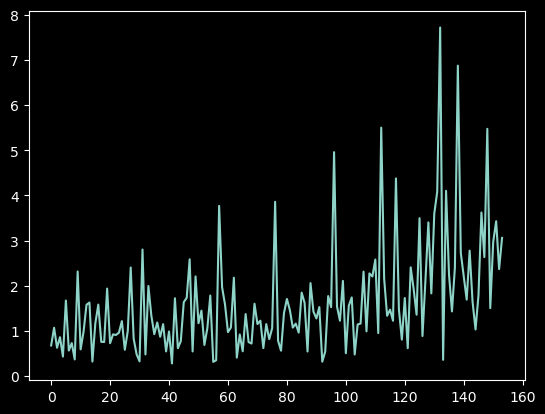

In [42]:
plt.plot(errors_polis)

# LSTM

In [43]:

import numpy as np
import tensorflow
from tensorflow.keras import Input
from tensorflow.keras import Model
import keras

from tensorflow.keras.layers import Dense, concatenate
from tensorflow.keras.layers import LSTM

In [44]:
def sampling(sequence, n_steps):
  sequence = sequence.tolist()
  X, Y = list(), list()

  for i in range(len(sequence)):

    sam = i + n_steps
    if sam > len(sequence)-1:
      break

    x, y = sequence[i:sam], sequence[sam]

    X.append(x)

    Y.append([y])

  return np.array(X), np.array(Y)


def fit_lstm(X, y, nb_epoch, n_neurons, additional=[], experts = [],n_batch=1):
    #n_batch=1
    tensorflow.keras.utils.set_random_seed(42)
    in1 = Input(batch_shape = (n_batch, X.shape[1], X.shape[2]))
    out1 = LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=False, activation='relu')(in1)
    out1 = Dense(50, activation='relu')(out1)
    if len(additional):
        if len(experts):
            add_input = additional #.reshape(additional.shape[0], additional.shape[1])
            in2 = Input(batch_shape = (n_batch, add_input.shape[1]))
            out2 = Dense(add_input.shape[1], activation='relu')(in2)
            out2 = Dense(50, activation='relu')(out2)

            exp_input = experts
            experts_input = experts #.reshape(additional.shape[0], additional.shape[1])
            in2_exp = Input(batch_shape = (n_batch, experts_input.shape[1]))
            out3 = Dense(experts_input.shape[1], activation='relu')(in2_exp)
            out3 = Dense(50, activation='relu')(out3)
            

            x = concatenate([out1, out2, out3]) 
            x = Dense(y.shape[1], activation='linear')(x)
            model = Model(inputs=[in1,in2,in2_exp], outputs=x)
            fitdat=[X,add_input,exp_input]
        else:
            add_input = additional #.reshape(additional.shape[0], additional.shape[1])
            in2 = Input(batch_shape = (n_batch, add_input.shape[1]))
            out2 = Dense(add_input.shape[1], activation='relu')(in2)
            out2 = Dense(50, activation='relu')(out2)
            x = concatenate([out1, out2]) 
            x = Dense(y.shape[1], activation='linear')(x)
            model = Model(inputs=[in1,in2], outputs=x)
            fitdat=[X,add_input]

    else:
        x = Dense(y.shape[1], activation='linear')(out1)
        model = Model(inputs=[in1], outputs=x)
        fitdat=[X]
    opt = keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(loss='mean_squared_error',metrics=['mape'], optimizer='adamax',  run_eagerly=True)
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        hist = model.fit(fitdat, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    #print(model.summary())
    return model,history_loss,history_val_loss



def make_forecast(model, train_df,lag, fwd):
    zfwd=np.array([])
    trg=train_df['instances'][-(lag +1):].values
    for i in range(fwd):
        X, y = sampling(trg, lag)
        X.shape
        inp=[X[:1]]
        inp[0].shape
        z=model.predict(inp, verbose=0)[0]
        zfwd=np.concatenate((zfwd, z))
        trg=np.concatenate((trg[1:], z))
    return zfwd


'''Линейное укладывание в диапазон [0,1], возвращает коэффициенты для восстановления (max(X))!=0'''
def Norm01(x):
    mi=np.nanmin(x)
    ma=np.nanmax(np.array(x)-mi)
    if ma>0.:
        x_n=(np.array(x)-mi)/ma
        return x_n, mi, ma
    else:
        return np.zeros(len(x)), mi, ma
'''Восстановление'''
def Nback(x_n, mi, ma):
    return x_n*ma+mi

136/136 [==============================] - 14s 99ms/step - loss: 0.0327 - mape: 38754016.0000 - val_loss: 0.0436 - val_mape: 28384714.0000


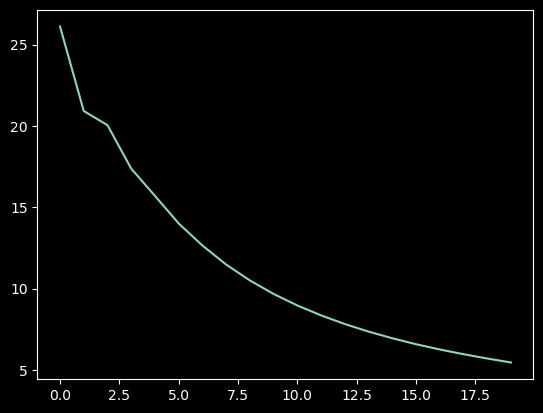

In [45]:
poly_test = valid_df['point'].unique().tolist()[0]


train_df = data_filtered[data_filtered['point'] == poly_test]

train_df = train_df[-200:]
train_df['norm'], mi, ma = Norm01(train_df['instances'])
lag = 48
X, y = sampling(train_df['norm'], lag)
X = np.expand_dims(X,2)
X.shape, y.shape
model2,history_loss2,history_val_loss = fit_lstm(X, y, 5, 50 ,n_batch = 1)


test_df = valid_df[valid_df['point'] == poly_test].sort_values(by=['hour'])
last_train = max(train_df['timestamp'])
last_test = max(test_df['hour'])
dates_to_pred = list(range(last_train+3600,last_test+3600, 3600))
#fwd = len(dates_to_pred)
fwd = 20
zfwd = make_forecast(model2, train_df,lag, fwd)
zfwd = Nback(zfwd, mi, ma)
plt.plot(zfwd)

# Make Final Pred

In [54]:

final_df = pd.DataFrame()

for poly_test in tqdm(valid_df['point'].unique().tolist()):
    
    train_df = data_filtered[data_filtered['point'] == poly_test]
    train_df = train_df[-400:]
    model = pmdarima.arima.ARIMA(order=(2, 0, 2), seasonal_order=(2, 0, 2, 24))
    y_train = train_df['instances']
    test_df = valid_df[valid_df['point'] == poly_test].sort_values(by=['hour'])
    last_train = max(train_df['timestamp'])
    last_test = max(test_df['hour'])
    dates_to_pred = list(range(last_train+3600,last_train+3600+3600*28*24, 3600))

    model.fit(train_df['instances'].tolist(), suppress_warnings = True)
    y_pred_test= model.predict(n_periods=len(dates_to_pred))
    pred_df = pd.DataFrame()
    final_df[str(poly_test)+'_date'] = dates_to_pred
    final_df[str(poly_test)] = y_pred_test.tolist()





100%|██████████| 154/154 [20:10<00:00,  7.86s/it]


In [55]:
final_df.to_csv('Storage/final_df.csv')